# The Air Quotes Cognition - Lab

In this assignment we take on noise, aka uncertainty, in exploration. Our venue is still chemotaxis. But now our sensors are noisy, or the world is "turbulent", or some other thing is happening to cause us doubt our senses. The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity. 

The decision to be made is this: is the gradient increasing or decreasing? 

We also introduce several targets.

We'll compare two exploring agents. The gradient searcher from _Sniff! Lab_ who, you may remember, operates akin to a _E. Coli_. A really simple model of an _E. Coli_, anyway. We'll also add in a new kind of gradient searcher, who uses a DDM-style accumulator to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature.

There are two sections. First we examine the accumulator. Second we compare it to our other agent, our naive sniffer. Here, in this section, there is a twist! The big idea for this twist I will spoil now. It is a question. Is it better to spend time rationally accumulating evidence, or is it better to just act? 

We'll play around with this big question in a simple way, by setting up something like a conservation law of "ticks" (aka steps). Steps can be spent thinking _or_ acting. I assume in this an agent can't think and act at the same time.

A bit of warning: in previous labs we have used only one metric. Either search efficiency, or total reward. In this lab, to really understand the thinking-action trade-off, we'll be looking at the results from a few more angles. These are:
- average reward 
- best reward
- total distance travelled
- number of deaths*

Any experimental trial which does not lead to finding at least a single target (aka reward) means the exploring agent dies. It's a harsh noisy world we live in, after all. 

## Install and import needed modules

In [1]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/parenthetical-e/explorationlib to /private/var/folders/nm/lks05xgj3hn20ntpdv1lrdyc0000gn/T/pip-req-build-rgxh9jn5
  Running command git clone -q https://github.com/parenthetical-e/explorationlib /private/var/folders/nm/lks05xgj3hn20ntpdv1lrdyc0000gn/T/pip-req-build-rgxh9jn5
  Created wheel for explorationlib: filename=explorationlib-0.0.1-cp36-none-any.whl size=14831 sha256=272626619aa01723867b42a28f4385e1c28bc9f4a5396d61f95b3ad70f0dfa65
  Stored in directory: /private/var/folders/nm/lks05xgj3hn20ntpdv1lrdyc0000gn/T/pip-ephem-wheel-cache-sgwlzfuz/wheels/f2/63/8a/9bc4a5fc4559289dfa95123fde31363e145e95df0cca3d2886
Successfully built explorationlib
  Found existing installation: explorationlib 0.0.1
    Uninstalling explorationlib-0.0.1:
      Successfully uninstalled explorationlib-0.0.1
  Cloning https://github.com/MattChanTK/gym-maze.git to /private/var/folders/nm/lks05xgj3hn20ntpdv1lrdyc0000gn/T/pip-req-build-0umijo9x
  Running command git clone -q https:/

In [3]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import GradientDiffusionCardinal
from explorationlib.agent import AccumulatorGradientCardinal

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death

In [4]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - patience, and the weight of evidence

In this section we'll start with a noisy, somewhat target-filled, domain and explore how speed, accuracy, and 

_Background_: Recall the model of scent in our (naive) _Sniff!_ agent (aka _GradientDiffusionDiscrete_) is as simple as can be. 

- When the scent gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_. 
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example). 
- If the agent "decides" to turn, the direction is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_

This same design holds for the accumulating sniffer, but it also can spend time sampling evidence in the same location. This should let us make better gradient decisions, in the very noisy world I will define anyway.

In this section we are going to examine how the _drift rate_ and the decision _threshold_ affect, best outcomes, average outcomes, and number of deaths. We'll examine these two parameters separately. Holding one or the other constant.

### Question 1.1

Based on what you have been told so far, how would you expect increases in _drift rate_ (aka the evidence rate) to effect average rewards, best rewards, and deaths in an open field task, with sparse targets and noisy scents?

Make your best guess, and explain yourself.

In [5]:
# Write your answer here as comment

### Question 1.2

Based on what you have been told so far, how would you expect increases in the decision _threshold_ (aka patience or "cognition" time) to effect average rewards, best rewards, and deaths in an open field task, with sparse targets and noisy scents.

Make your best guess, and explain yourself.

In [6]:
# Write your answer here as comment. Explain yourself.

The name of the env for this section is once again the _ScentGrid_. 

Let's add some targets and scents to it.

In [7]:
# Shared exp parameters
num_experiments = 200
num_steps = 200
max_steps = 10
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250 
target_boundary = (100, 100)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
coord, scent = create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Using the _env_ defined above explore the following drift rates
### Drift rates

In [8]:
# Our parameters 
drift_rates = [0.25, 0.75, 1.0, 1.25, 1.5]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = list(range(5))

### Run
200 experiments for each drift rate

In [82]:
# Exp params
threshold = 3.0
accumulate_sigma = 1.0

# !
results = []
for i, drift_rate in zip(names, drift_rates):
    accum = AccumulatorGradientCardinal(
        min_length=min_length, 
        max_steps=max_steps, 
        drift_rate=drift_rate, 
        threshold=threshold,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_Sniff: 100%|██████████| 200/200 [02:53<00:00,  1.15it/s]


#### Plot an example

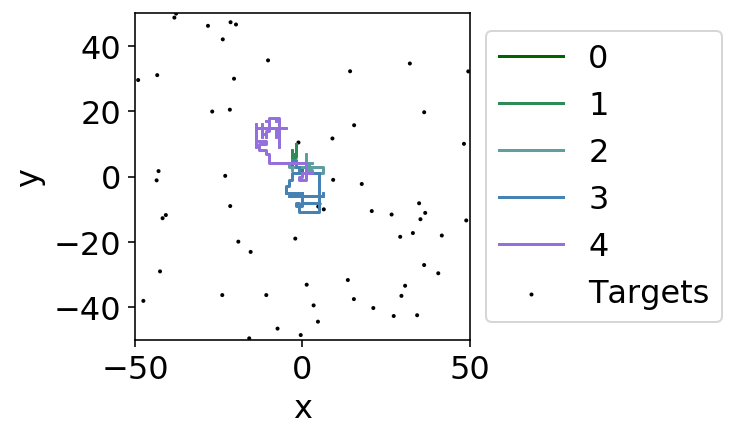

In [10]:
plot_boundary = (50, 50)
num_experiment = 0
ax = None
for i, result, color in zip(names, results, colors):
    ax = plot_position2d(
        select_exp(result, num_experiment),
        boundary=plot_boundary,
        label=i,
        color=color,
        alpha=1,
        ax=ax,
    )
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

#### Plot several metrics
Distance, death, best reward, average reward

Note: the model code follows the _drift rate_, See the def. of "names" above.

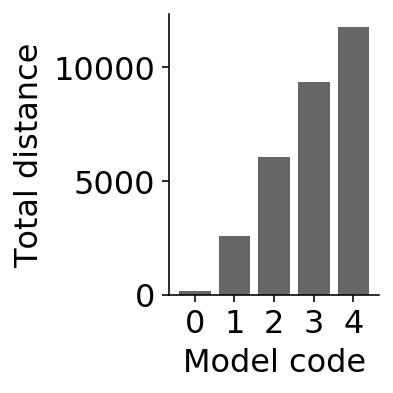

In [11]:
# Score
scores = []
for result in results:  
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

num_death: 100%|██████████| 200/200 [00:00<00:00, 18318.14it/s]


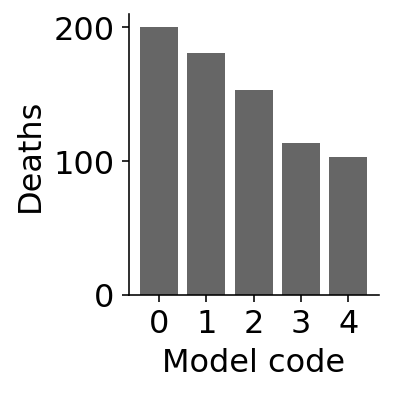

In [12]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 200/200 [00:00<00:00, 9032.93it/s]


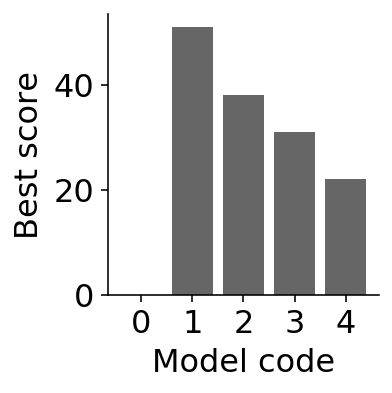

In [13]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 200/200 [00:00<00:00, 17809.45it/s]


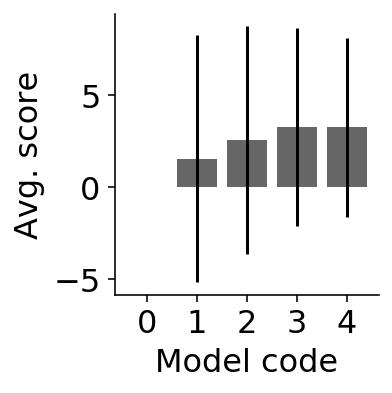

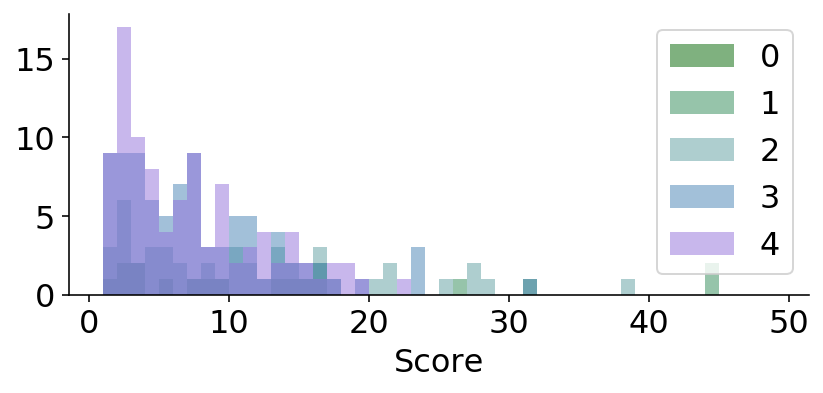

In [14]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 1.3
Based on the plots above, in your own words summarize the relationship between _drift rate_ and total distance, number of deaths, best reward and average reward.

In [15]:
# Write your answer here as comment. Explain yourself.

### Question 1.4
Recall that the larger the drift rate, the faster the agent will reach a decision. Based on the above do you think it's better to be faster to choose, or more accurate in this task?

In [16]:
# Write your answer here as comment. Explain yourself.

### Thresholds
Explore five thresholds, in the same environment.

In [17]:
# Our parameters 
thresholds = [0.1, 1.0, 2.0, 3.0, 4.0]
# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = list(range(5))

### Run 
200 experiments

In [18]:
# -
results = []
for i, threshold in zip(names, thresholds):
    accum = AccumulatorGradientCardinal(
        min_length=min_length, 
        max_steps=max_steps, 
        drift_rate=drift_rate, 
        threshold=threshold,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_4: 100%|██████████| 200/200 [02:20<00:00,  1.42it/s]


#### Plot an example

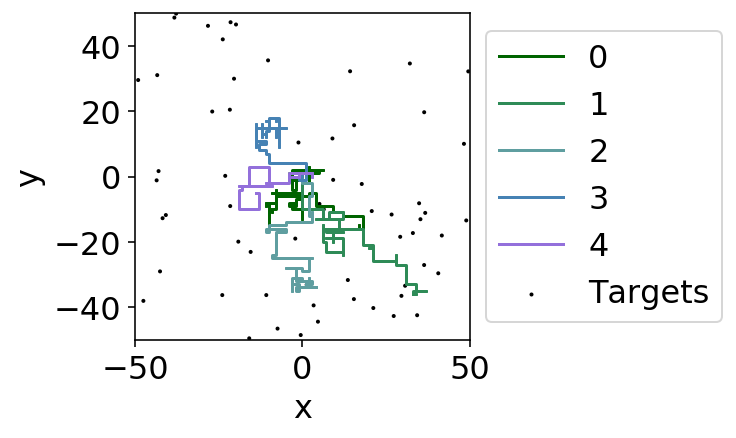

In [19]:
plot_boundary = (50, 50)
num_experiment = 0
ax = None
for i, result, color in zip(names, results, colors):
    ax = plot_position2d(
        select_exp(result, num_experiment),
        boundary=plot_boundary,
        label=i,
        color=color,
        alpha=1,
        ax=ax,
    )
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

#### Plot several metrics
Distance, death, best reward, average reward

Note: the model code follows the _drift rate_, See the def. of "names" above.

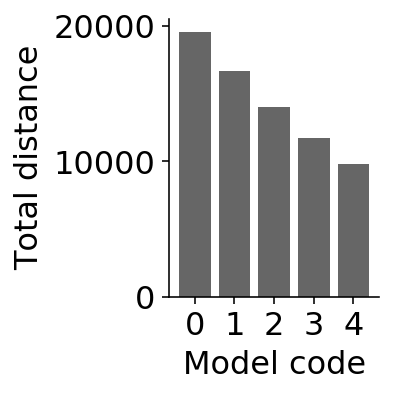

In [20]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

num_death: 100%|██████████| 200/200 [00:00<00:00, 16806.80it/s]


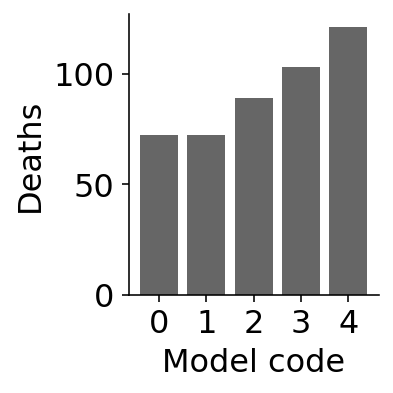

In [21]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 200/200 [00:00<00:00, 20569.39it/s]


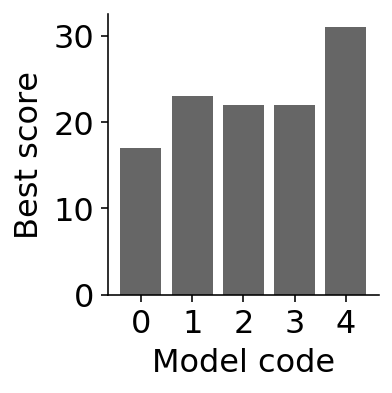

In [22]:
# Score
scores = []
for result in results: 
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()


total_reward: 100%|██████████| 200/200 [00:00<00:00, 28065.87it/s]


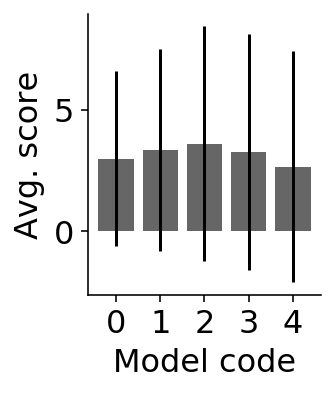

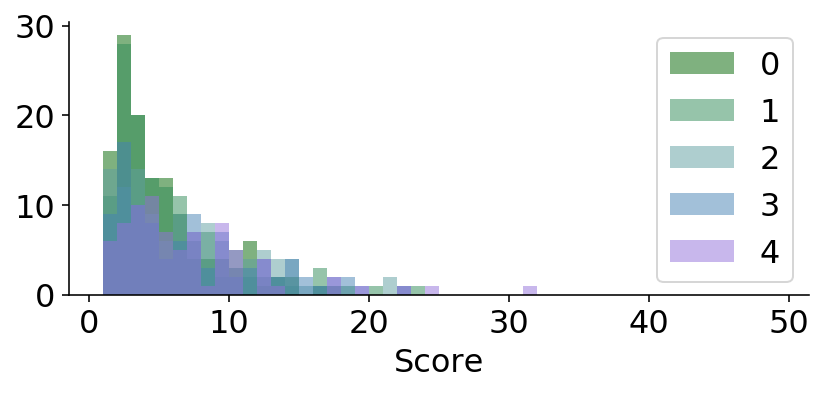

In [23]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# -
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 1.5
Based on the plots above and in your own words, summarize the relationship between the decision _threshold_ and the total distance, number of deaths, best reward and average reward.

In [24]:
# Write your answer here as comment. Explain yourself.

### Question 1.6
Make a prediction. Based on your observations and answers to all the questions in this section, do you think an accumulator is needed? That is, will it perform better, or worse, than the naive sniffer in this task?

In [25]:
# Write your answer here as comment. Explain yourself.

### Question 1.7
Let's get philosophical. Is it better to gamble on being the best, knowing you risk death (in this task) or is it better to be average and alive? 

What parameters from the above do you _personally_ prefer. There is no right answer. Be yourself.

In [26]:
# Write your answer here as comment. Explain yourself.

## Section 2 - the evidence is in?

In this section we'll start in the same noisy, somewhat target-filled, domain as Section 1. This time we'll compare the naive sniffer, to an accumulator model. I have chosen parameters for each to be good enough. (No need to fiddle).

The parameter of interest here is the number of steps, _num steps_, each agent can take. 

In previous labs the number of steps meant the number of steps or actions the agent took in the environment. Now, here, it can mean two things for the accumulator agent. A step can be spent sampling/weighing noisy scent evidence in the same location, or it can be spent moving to a new location. 

### Question 2.1
For the same number of steps (200), make a brute guess. Which will do better, the naive sniffer or the accumulator? 

In your answer assume I have given you good parameter choices, so all things are held equal, more or less. I believe I have done so.

In [27]:
# Write your answer here as comment. Explain yourself.

### Run 

Let's find out if you were right

In [28]:
# Experiment settings
num_experiments = 200
num_steps = 200
max_steps = 10
seed_value = 42

# Fixed
min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250 # 5000-50000
target_boundary = (100, 100)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
coord, scent = create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)


In [29]:
# Agents
sniff = GradientDiffusionCardinal(
    min_length=min_length, 
    scale=1.0, 
    p_neg=1, 
    p_pos=0.0
)
sniff.seed(seed_value)

accum = AccumulatorGradientCardinal(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
accum.seed(seed_value)

# !
accum_exp = experiment(
    f"data/test_accum.pkl",
    accum,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
sniff_exp = experiment(
    f"data/test_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

test_sniff: 100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


In [ ]:
# Join 
results = [accum_exp, sniff_exp]
names = ["Accum", "Sniff"]
colors = ["blue", "green"]

#### Example

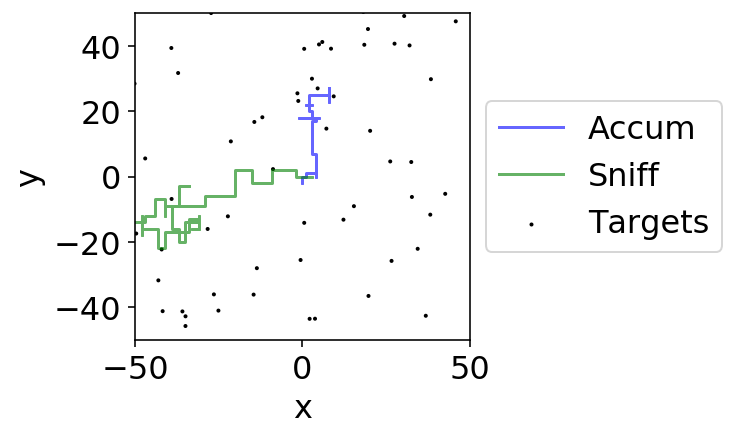

In [74]:
plot_boundary = (50, 50)

num_experiment = 54
ax = None
ax = plot_position2d(
    select_exp(accum_exp, num_experiment),
    boundary=plot_boundary,
    label="Accum",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

#### Plot several metrics
Distance, death, best reward, average reward

Note: the model code follows the _drift rate_, See the def. of "names" above.

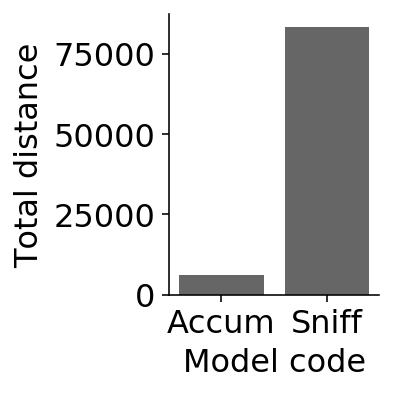

In [75]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in res:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar(names, scores, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

num_death: 100%|██████████| 200/200 [00:00<00:00, 8626.17it/s]


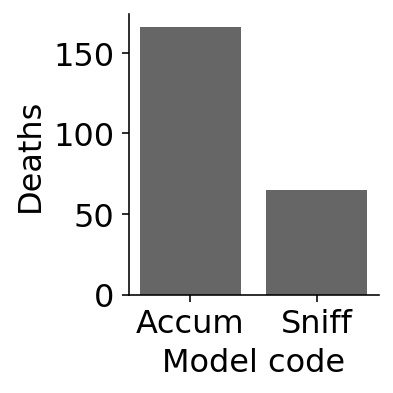

In [76]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar(names, scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 200/200 [00:00<00:00, 26267.76it/s]


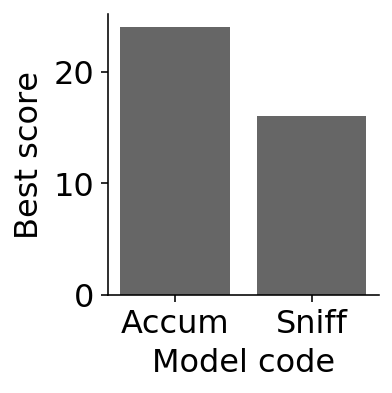

In [77]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in zip(scores):
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 200/200 [00:00<00:00, 25974.14it/s]


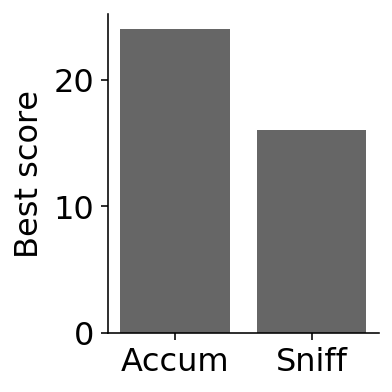

In [78]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 200/200 [00:00<00:00, 14876.32it/s]


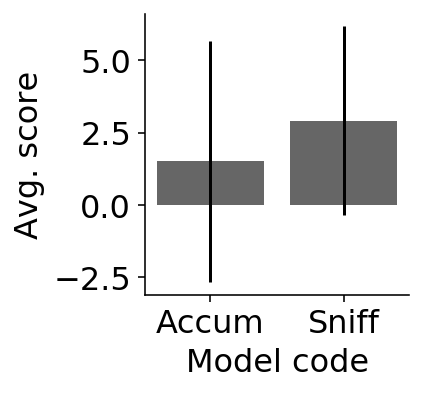

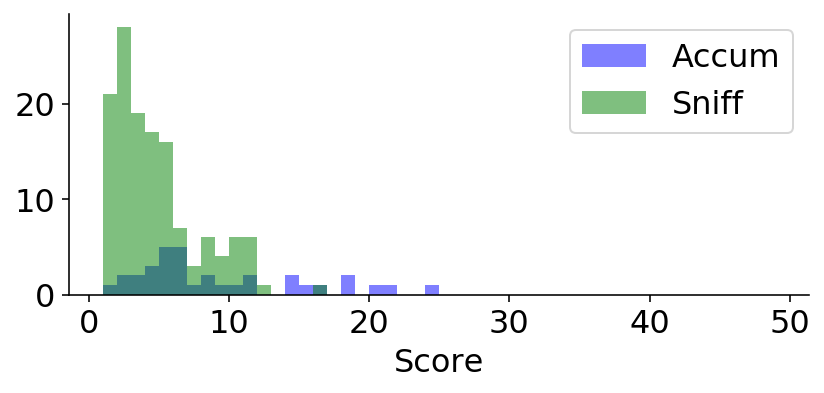

In [79]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# -
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 2.2

Was your answer to Q 2.1 correct? 

If it was right, tell me how smart you are, and how bright your brillant star shines, in a 5-7-5 Haiku. If you were wrong, tell me why you think that was. Also, do this in the form of a 5-7-5 Haiku.

In [80]:
# Write your answer here as comment. Explain yourself.

Let's try and give the accumulator some more time to do its work, but keep the steps the naive sniffer has the same. 

Let's call this the _cognitive multiplier_ (cog mult). To keep things sane, let's cap the values of the cog mult between 1 and 10. 

### Question 2.3

In the given range how much past 1 does the _cog mult_ need to be set to ensure the number of deaths is the same between the models? Make a guess. if you can, explain why.

In [81]:
# Write your answer here as comment. 

### Run
Let's find out if you were right.

Use the code below to find a _cog mult_ value (1-10) that has about equal number of deaths for each of the agents. No need to be exact. Get them close.

In [ ]:
# Experiment settings
cog_mult = 1

# Agents
sniff = GradientDiffusionCardinal(
    min_length=min_length, 
    scale=1.0, 
    p_neg=1, 
    p_pos=0.0
)
sniff.seed(seed_value)
accum = AccumulatorGradientCardinal(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
accum.seed(seed_value)

# !
accum_exp = experiment(
    f"data/test_accum.pkl",
    accum,
    env,
    num_steps=cog_mult*num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
sniff_exp = experiment(
    f"data/test_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

In [ ]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
names = list(range(5))
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

### Question 2.4

What is the final value of _cog mult_ you chose?

In [ ]:
# Write your answer here as comment. 

### Question 2.4

Do you think that equalizing deaths will cause the accumulator to outperform the naive sniffer in distance travelled, max reward, and average reward? Explain your answer for each metric.

In [ ]:
# Write your answer here as comment. Explain yourself

### Run 

Let's find out if you were right. Run experiment code immediately above, with your final value of _cog mult_. Once done, come back here and run the cells below to plot the results.

In [ ]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
names = list(range(5))
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

In [ ]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

In [ ]:
# Score
scores = []
for result in results:
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.tight_layout()
sns.despine()

In [ ]:
# Score
scores = []
for i, result, color in zip(names, results, colors):    
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# -
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 2.5

In light of all this, when is it better to weigh evidence, in an optimal way, as our accumulator does, and when it is better to just act? Phrase your answer in terms of the number of "extra" steps an accumulator needs.

In [ ]:
# Write your answer here as comment. Explain yourself

### Question 2.6

Perhaps animals need a minimal time, or minimal resources, for cognition to pay out!? Do you think this simple lab would let us reach such a broad conclusion as this last question suggests? Let's assume not! Provide please a counterexample - a change to the task which would ensure evidence accumulation is _always_ worthwhile. _Or_, a change to make it never worthwhile. Either or, that is.

In [ ]:
# Write your answer here as comment. Explain yourself